## Narzędzie graficzne

In [1]:
import math

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import pandas as pd

TOLERANCE = 0.20

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
          
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points
        
    def get_points(self):
        return self.points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]

    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
%matplotlib notebook

In [3]:
def get_points_from_plot(plot):
        points = [] 
        lines = plot.get_added_figure()[0].lines
        for line in lines:
            points.append(line[0])
        return points
def points_to_lines(points):
    lines = []
    for i in range(len(points)):
        lines.append((points[i-1],points[i]))
    return lines

<IPython.core.display.Javascript object>


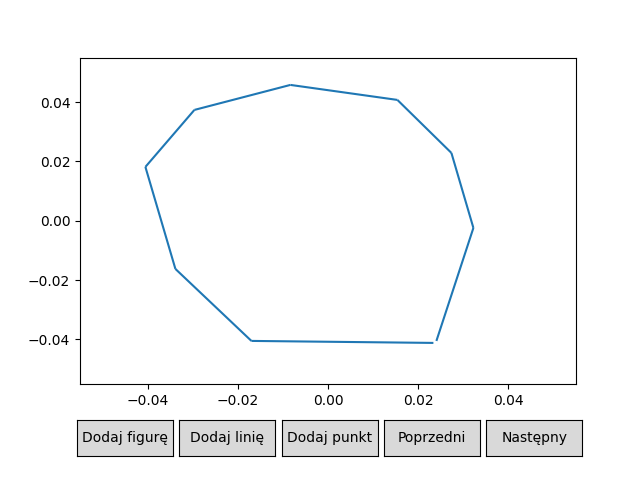

In [47]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [48]:
data1=get_points_from_plot(plot)

<IPython.core.display.Javascript object>


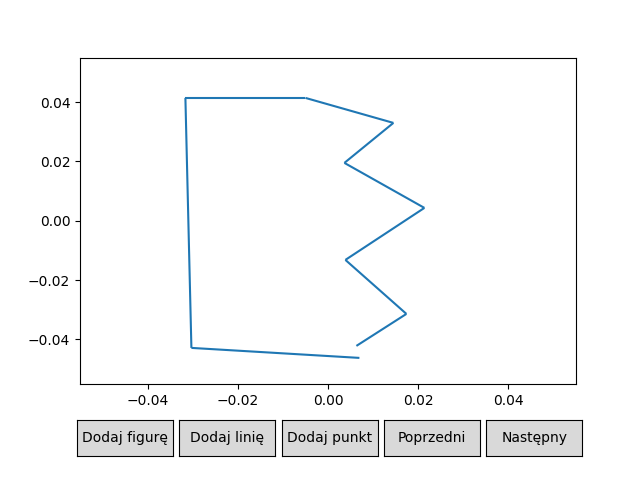

In [6]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [7]:
data2 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


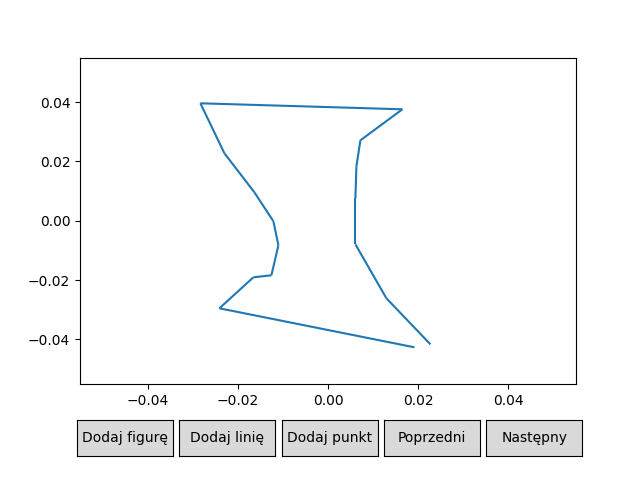

In [8]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [9]:
data3 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


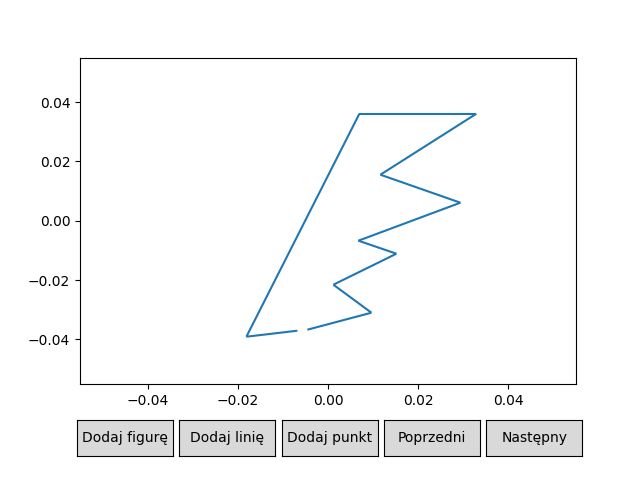

In [10]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [11]:
data4 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


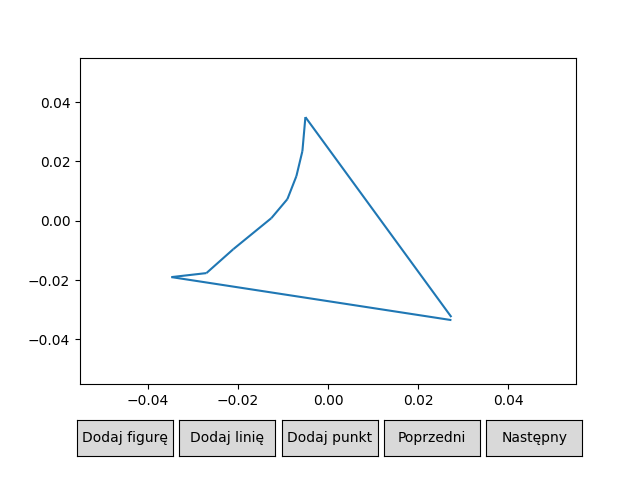

In [12]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [13]:
data5 = get_points_from_plot(plot)

## Zapis punktów do CSV

In [4]:
def save_to_csv(data, name):
    df = pd.DataFrame()
    df['Points']=data
    df.to_csv(name, index=False)

In [34]:
save_to_csv(data1,"Punkty_1.csv")
save_to_csv(data2,"Punkty_2.csv")
save_to_csv(data3,"Punkty_3.csv")
save_to_csv(data4,"Punkty_4.csv")
save_to_csv(data5,"Punkty_5.csv")

## Pobieranie punktów z CSV

In [4]:
def get_points_from_csv(name):
    result=[]
    data=pd.read_csv(name)
    for line in data['Points']:
        line = line.replace("(","")
        line = line.replace(")","")
        line = line.split(", ")
        result.append((float(line[0]),float(line[1])))
    return result

In [5]:
data1=get_points_from_csv("Punkty_1.csv")
data2=get_points_from_csv("Punkty_2.csv")
data3=get_points_from_csv("Punkty_3.csv")
data4=get_points_from_csv("Punkty_4.csv")
data5=get_points_from_csv("Punkty_5.csv")

In [6]:
def maxY_index(points):
    maximum=float('-inf')
    index=-1
    for i in range(len(points)):
        if points[i][1]>maximum:
            maximum=points[i][1]
            index=i
    return index

def minY_index(points):
    minimum=float('inf')
    index=-1
    for i in range(len(points)):
        if points[i][1]<minimum:
            minimum=points[i][1]
            index=i
    return index

def yMonotony(points):
    top=maxY_index(points)
    bottom=minY_index(points)
    i=top
    while i != bottom:
        next_point=(i+1)%len(points)
        if points[next_point][1]>points[i][1]:
            return False       
        i=next_point
    i=bottom
    
    i=bottom
    while i != top:
        next_point=(i+1)%len(points)
        if points[next_point][1]<points[i][1]:
            return False       
        i=next_point
        
    return True

In [7]:
epsilon = 10**(-12)
def matrix_2x2(a,b,c):
    return [[a[0]-c[0], a[1]-c[1]], [ b[0]-c[0], b[1]-c[1]]]

def det_2x2(a,b,c):
    matrix=matrix_2x2(a,b,c)
    return (matrix[0][0]*matrix[1][1])-(matrix[0][1]*matrix[1][0])

def is_in_polygon(a,b,c, number):
    if number == 0:
        return det_2x2(a,b,c) > epsilon
    else:
        return det_2x2(a,b,c) <- epsilon

# Triangulacja z ćwiczeń

In [8]:
def triangulation(points):
    if not yMonotony(points):
        print("Wielokat nie jest y-monotoniczny")
        return None, None
    
    maximum_index = maxY_index(points)
    minimum_index = minY_index(points)
    
    specified_points= []
    i=maximum_index
    while i!=minimum_index:
        specified_points.append((points[i],0,i))
        i=(i+1)%len(points)
    while i!=maximum_index:
        specified_points.append((points[i],1,i))
        i=(i+1)%len(points)
    specified_points.sort(reverse = True, key = lambda x: x[0][1])
    
    diagonals = []
    stack = []
    scenes = []
    diagonal_index=[]
    
    stack.append(specified_points[0])
    stack.append(specified_points[1])
    diagonals.append([specified_points[0][0], specified_points[1][0]])
    diagonal_index.append((specified_points[0][2],specified_points[1][2]))
    scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[0][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))    
    scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[1][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
    
    for i in range(2, len(specified_points)):
        if stack[-1][1] != specified_points[i][1]:
            while len(stack) > 0:
                new_verticle = stack.pop()
                diagonals.append([new_verticle[0], specified_points[i][0]])
                diagonal_index.append((new_verticle[2],specified_points[i][2]))
                scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[i][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
            stack.append(specified_points[i-1])
            stack.append(specified_points[i])
        else:
            new_verticle = stack.pop()
            diagonals.append([specified_points[i][0], new_verticle[0]])
            diagonal_index.append((specified_points[i][2],new_verticle[2]))
            scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[i][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
            while len(stack) > 0 and is_in_polygon(specified_points[i][0], stack[-1][0], new_verticle[0], specified_points[i][1]):
                new_verticle = stack.pop()
                diagonals.append([new_verticle[0], specified_points[i][0]])
                diagonal_index.append((new_verticle[2], specified_points[i][2]))
                scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[i][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
            stack.append(new_verticle)
            stack.append(specified_points[i])
  
    final_scene = Scene([PointsCollection(points)], [LinesCollection(diagonals.copy(), color="black")])
    scenes = [final_scene] + scenes
                        
    return diagonal_index, scenes

<IPython.core.display.Javascript object>


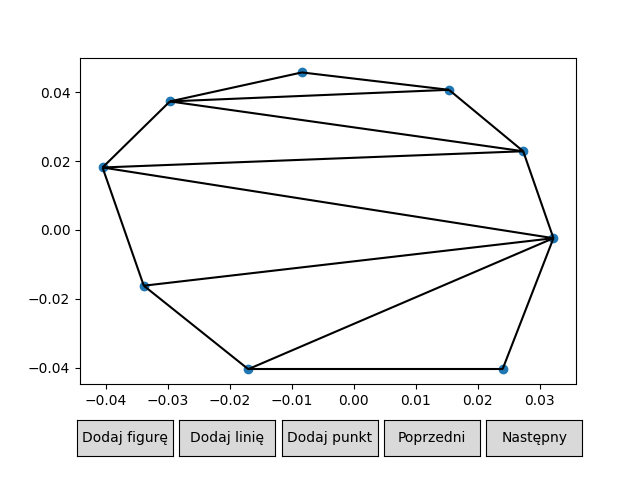

In [9]:
_, data = triangulation(data1)
plot = Plot(data)
plot.draw()

# TRIANGULACJA DELAUNAY'A CHYBA POPRAWNA

In [25]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [37]:
class Triangle:
    def __init__(self, p1: Point, p2: Point, p3: Point):
        self.p1 = p1    # pierwszy punkt
        self.p2 = p2    # drugi punkt
        self.p3 = p3    # trzeci punkt
        self.orient_counterclockwise()   # przypisanie funkcji do ustawienia orientacji punktów przeciwnie do wskazówek zegara
        self.edges = self.determine_edges()  #przypisanie funkcji do wykrywania krawędzi
        return

    def points(self):
        return [self.p1, self.p2, self.p3]


    def determine_edges(self):
        """
        Simply calculates the midpoint between the 3 pairs of points:
        
        Edge 1 => (P1, P2)
        Edge 2 => (P2, P3)
        Edge 3 => (P3, P1)
        """
        def midpoint(p1: Point, p2: Point):
            return Point((p1.x + p2.x) / 2, (p1.y + p2.y) / 2)

        edges = []
        edges.append(midpoint(self.p1, self.p2))
        edges.append(midpoint(self.p2, self.p3))
        edges.append(midpoint(self.p3, self.p1))
        return edges


#     def plot(self, points=None, x_limits=(0,10), y_limits=(0,10)):
#         plt.figure()
#         plt.xlim(x_limits)
#         plt.ylim(y_limits)

#         plt.plot([self.p1.x, self.p2.x, self.p3.x, self.p1.x],[self.p1.y, self.p2.y, self.p3.y, self.p1.y], '*-')
#         if points:
#             plt.plot([p.x for p in points], [p.y for p in points], '.k')
        
#         plt.show()


    def is_linear(self):
        return abs((self.p2.y - self.p1.y)*(self.p3.x - self.p2.x) - (self.p3.y - self.p2.y)*(self.p2.x - self.p1.x)) <= 1e-3 


    def orient_counterclockwise(self):
        val = (self.p2.y - self.p1.y)*(self.p3.x - self.p2.x) - (self.p3.y - self.p2.y)*(self.p2.x - self.p1.x)
        if val > 0:
            # Orient the tri counterclockwise by swapping p2 and p3.
            self.p3, self.p2 = self.p2, self.p3
#             print(f"Orientation of {self} has been corrected to be counterclockwise.")
        return 


    def circumcircle_contains_point(self, p: Point):
        Ax = self.p1.x
        Bx = self.p2.x
        Cx = self.p3.x
        Dx = p.x

        Ay = self.p1.y
        By = self.p2.y
        Cy = self.p3.y
        Dy = p.y

        # Alternate derivation:
        # mat = np.array([
        #     [Ax, Ay, Ax**2 + Ay**2, 1],
        #     [Bx, By, Bx**2 + By**2, 1],
        #     [Cx, Cy, Cx**2 + Cy**2, 1],
        #     [Dx, Dy, Dx**2 + Dy**2, 1]
        # ])

        mat = np.array([
            [Ax - Dx, Ay - Dy, (Ax**2 - Dx**2) + (Ay**2 - Dy**2)],
            [Bx - Dx, By - Dy, (Bx**2 - Dx**2) + (By**2 - Dy**2)],
            [Cx - Dx, Cy - Dy, (Cx**2 - Dx**2) + (Cy**2 - Dy**2)]
        ])

        return np.linalg.det(mat) > 0

In [38]:
class DelaunayTriangulation:
    def __init__(self, points):
        self.points = points
        self.triangles = []
        self.triangulate()
        scenes=[]

    def triangulate(self):

        def points_overlap(p1: Point, p2: Point):
            return ((p1.x - p2.x)**2 + (p1.y - p2.y)**2)**0.5 <= 1e-6


        def find_solitary_edges(bad_triangles):
            solitary_edges = []

            # Brute-force method to determine conflicts:
            for tri_i_index, tri_i in enumerate(np.array(self.triangles)[bad_triangles]):
                for edge_midpoint_i_index, edge_midpoint_i in enumerate(tri_i.edges):
                    no_conflicts = True
                    
                    for tri_j_index, tri_j in enumerate(np.array(self.triangles)[bad_triangles]):
                        if tri_i_index != tri_j_index: # Making sure we don't compare the same triangle.
                            for edge_midpoint_j_index, edge_midpoint_j in enumerate(tri_j.edges):
                                
                                if points_overlap(edge_midpoint_i, edge_midpoint_j):
                                    no_conflicts = False

                    if no_conflicts:
                        p1, p2, p3 = tri_i.p1, tri_i.p2, tri_i.p3

                        if edge_midpoint_i_index == 0:
                            solitary_edges.append((p1, p2))
                        elif edge_midpoint_i_index == 1:
                            solitary_edges.append((p2, p3))    
                        elif edge_midpoint_i_index == 2:
                            solitary_edges.append((p3, p1))
                
            return solitary_edges


        def remove_bad_triangles(bad_triangles):
            bad_triangles.sort(reverse=True)
            for bad_tri in bad_triangles:
                del self.triangles[bad_tri]
            return


        # Generating the "super triangle":
        x_max = max([p.x for p in self.points])
        y_max = max([p.y for p in self.points])
        x_min = min([p.x for p in self.points])
        y_min = min([p.y for p in self.points])

        s1 = Point(x_min - (x_max - x_min), y_min - (y_max - y_min))
        s2 = Point(x_max + (x_max - x_min), y_min - (y_max - y_min))
        s3 = Point(0, y_max + (y_max - y_min))
    
    
        super_triangle = Triangle(s1, s2, s3)
        self.triangles.append(super_triangle)
        # Debug plot => super_triangle.plot(self.points, x_limits=(s3.x,s2.x), y_limits=(s2.y, s1.y))

        # Inserting each point for triangulation:
        for p in self.points:
            
            # Determine the bad triangles:
            bad_triangles = []
            for i, tri in enumerate(self.triangles):

                if tri.circumcircle_contains_point(p):
                    # This is a triangle that needs to be deleted.
                    bad_triangles.append(i)
            
            # Determine the bad polygon:
            polygon = find_solitary_edges(bad_triangles) 

            # Remove all bad triangles:
            remove_bad_triangles(bad_triangles)

            # Create new triangles from the solitary edges stored in polygon:
            for solitary_edge in polygon:
                new_tri = Triangle(p, solitary_edge[0], solitary_edge[1])
                self.triangles.append(new_tri)
                # Debug plotting => new_tri.plot(x_limits=(s3.x,s2.x), y_limits=(s2.y, s1.y))

        # Debug plot => self.plot()
        
        # Remove all triangles that contain any of the vertices of the "super triangle":
        bad_triangles = []
        for i, tri in enumerate(self.triangles):
            for point in tri.points():

                if points_overlap(point, s1) or points_overlap(point, s2) or points_overlap(point, s3):
                    bad_triangles.append(i)
                    break

        remove_bad_triangles(bad_triangles)

        return 


    def plot(self):
        plt.figure()

        for tri in self.triangles:
            plt.plot([tri.p1.x, tri.p2.x, tri.p3.x, tri.p1.x], [tri.p1.y, tri.p2.y, tri.p3.y, tri.p1.y], '-k')
        
        plt.plot([p.x for p in self.points], [p.y for p in self.points], '.r')
        plt.plot([self.points[i%len(self.points)].x for i in range(len(self.points)+1)],
                 [self.points[i%len(self.points)].y for i in range(1+len(self.points))], '-b')
        plt.show()
        return



<IPython.core.display.Javascript object>


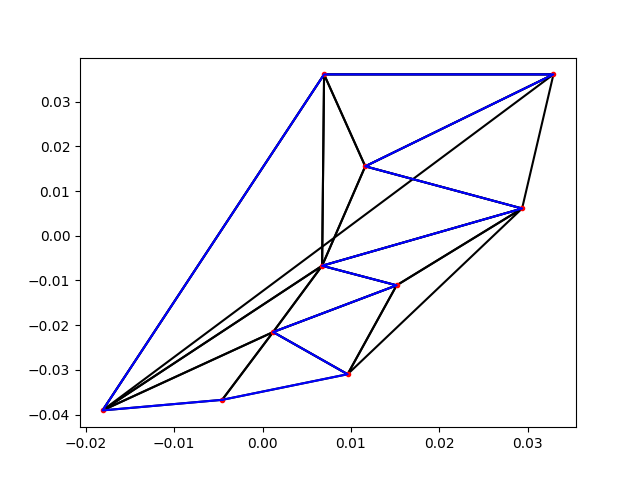

In [43]:
points = [Point(x, y) for x, y in data4]
delaunay = DelaunayTriangulation(points)
delaunay.plot()

<IPython.core.display.Javascript object>


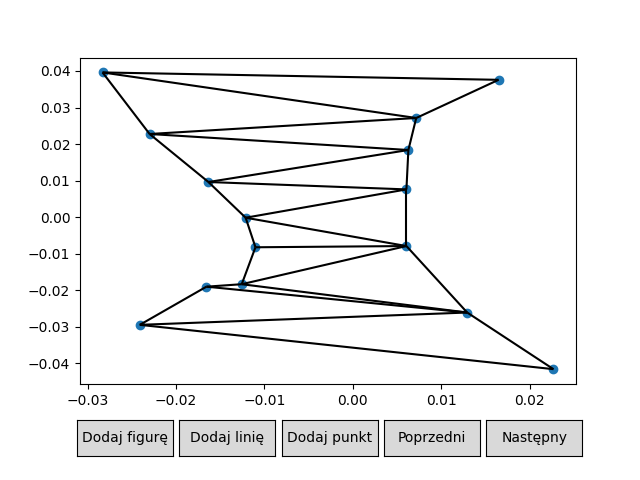

In [45]:
_ , data = triangulation(data3)
plot = Plot(data)
plot.draw()

# ---------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------

# NOWE AYRON GITHUB

In [53]:
#from math import ceil, sqrt, log, floor

# Ref: https://www.cs.cmu.edu/~quake/tripaper/triangle2.html
# Ref: http://www.geom.uiuc.edu/~samuelp/del_project.html
# Ref: http://web.engr.oregonstate.edu/~mjb/cs553/Handouts/Resampling/resampling.1pp.pdf

def dot(a, b):

    return a.x*b.x + a.y*b.y + a.z*b.z

def cross(a, b):

    return Point( a.y*b.z-a.z*b.y, a.z*b.x-a.x*b.z, a.x*b.y-a.y*b.x )


class Point:

    def __init__(s, x, y, z=0):
        s.x = x
        s.y = y
        s.z = z

    def __repr__(s):

        return "( " + str(s.x) + ", " + str(s.y) + " )"

    def __add__(s, b):

        return Point(s.x+b.x, s.y+b.y)

    def __sub__(s, b):

        return Point(s.x-b.x, s.y-b.y)

    def __mul__(s, b):

        return Point(b*s.x, b*s.y)

    __rmul__ = __mul__

    def IsIn(self, t):
        ''' Checks to see if p is in t using the barycenter method'''
        b = t.v[1] - t.v[0]
        c = t.v[2] - t.v[0]
        d = self   - t.v[0]

        det = c.x*b.y-c.y*b.x;
        u = (d.x*b.y-d.y*b.x)//float(det);
        v = (c.x*d.y-c.y*d.x)//float(det);

        return u >= 0 and v >= 0 and u + v < 1

    def IsInCircumcircleOf(self, T):

        a = T.v[0] - T.v[2]
        b = T.v[1] - T.v[2]

        # Ref: https://en.wikipedia.org/wiki/Circumscribed_circle#Circumcircle_equations
        z = cross(a,b)
        p0 = cross(dot(a,a)*b-dot(b,b)*a, z)*(0.5/dot(z,z)) + T.v[2]

        r2 = 0.25*dot(a, a)*dot(b,b)*dot(a-b, a-b)/dot(z, z)

        #print "IsInC"
        #print self, p0
        #print sqrt(r2), "\n"
        #print 

        return dot(self-p0, self-p0) <= r2

class Triangle:


    def __init__(self, a, b, c):
        
        self.v = [None]*3
        self.v[0] = a
        self.v[1] = b
        self.v[2] = c

        self.neighbour = [None]*3    # Adjacent triangles


    def __repr__(s):

        '''
        return '<%s, [%s, %s, %s]>' % (
                hex(id(s)), 
                hex(id(s.neighbour[0])), 
                hex(id(s.neighbour[1])), 
                hex(id(s.neighbour[2])))
        '''
        return '< ' + str(s.v) + ' >'

    #def vOppositeOf(self, T):
    #
    #   return self.v[(self.neighbour.index(T))] 

    #def ReplaceNeighbour(self, A, B):
    #   
    #    self.neighbour[self.neighbour.index(A)] = B
        
    def SetEdge(self, edge, T):
        'Set the edge neighbour that matches "edge" to T'

        temp_v = self.v + self.v[0:1]
        for i in range(3):
            if edge[0] == temp_v[i] and edge[1] == temp_v[i+1]:
                self.neighbour[(i+2)%3] = T
                return
        print ('This function should never get this far')
        print (edge)
        print (temp_v)
        print (T)

    #def RightOf(self, T):
    #    ''' Find the neighbour that is right of (ccw) neighbour T'''
    #    ''' Assumed neighbours are indexed ccw'''
    #
    #    return self.neighbour[(self.neighbour.index(T) + 1) % 3]

    #def LeftOf(self, T):
    #    
    #    return self.neighbour[(self.neighbour.index(T) - 1) % 3]


class Delaunay_Triangulation:
    """Bowyer Watson"""

    def __init__(self):

        # Create a two triangle 'frame'
        
        a = Point(-0.5, -0.5)
        b = Point(0.5, -0.5)
        c = Point(0.5, 0.5)
        d = Point(-0.5, -0.5)

        T1 = Triangle(a, d, b)
        T2 = Triangle(c, b, d)

        T1.neighbour[0] = T2
        T2.neighbour[0] = T1

        self.triangles = [T1, T2]


    def AddPoint(self, p):
       
        bad_triangles = []

        # Search for the triangle where the point is.
        ''' For now I am just doing a naive search,
        but I hope to replace this with an initial guess
        and a BFS'''
        for T in self.triangles:
            
            if p.IsInCircumcircleOf(T):
                bad_triangles.append(T)


        # Find the convex hull of the bad triangles.
        # Expressed a list of edges (point pairs) in ccw order
        boundary = self.Boundary(bad_triangles)


        for T in bad_triangles:
            self.triangles.remove(T)

        # Retriangle to hole
        new_triangles = []
        for edge in boundary:
            T = Triangle(p, edge[0], edge[1])

            T.neighbour[0] = edge[2]                   # To neighbour
            if T.neighbour[0]:
                T.neighbour[0].SetEdge(edge[1::-1], T)     # from neighbour

            new_triangles.append(T)

        # Link the new triangles
        N = len(new_triangles)
        for i, T in enumerate(new_triangles):
            T.neighbour[2] = new_triangles[(i-1) % N]   # back
            T.neighbour[1] = new_triangles[(i+1) % N]   # forward
   
        self.triangles.extend(new_triangles)

      
    def Boundary(self, bad_triangles):

        # Start with a triangle at random
        T = bad_triangles[0]
        edge = 0

        boundary = []

        while True:
            
            if len(boundary) > 1:
                if boundary[0] == boundary[-1]:
                    break

            if T.neighbour[edge] in bad_triangles:

                last = T
                T = T.neighbour[edge]

                edge = (T.neighbour.index(last) + 1) % 3 

            else:   # Found an edge that is on the boundary
                # Add to list
                boundary.append((T.v[(edge+1)%3], T.v[(edge+2)%3], T.neighbour[edge]))
                edge = (edge + 1) % 3

        return boundary[:-1]

    def export(self):

        ps = [p for t in self.triangles for p in t.v ]

        xs = [p.x for p in ps]
        ys = [p.y for p in ps]
        
        #xs = list(set(xs))
        #ys = list(set(ys))

        ts = [(ps.index(t.v[0]), ps.index(t.v[1]), ps.index(t.v[2])  ) for t in self.triangles]

        return xs, ys, ts



In [54]:
from random import randint, seed
from math import ceil, sqrt, log, floor


seed(4)
n = len(data1)
# xs = [randint(1, 98) for x in range(n)]
# ys = [randint(1, 98) for x in range(n)]
zs = [0 for x in range(n)]

xs = [n[0] for n in data1]
ys = [n[1] for n in data1]

DT = Delaunay_Triangulation()

for x, y in zip(xs, ys):
    DT.AddPoint(Point(x, y))

XS, YS, TS = DT.export()


for tmp in TS:
    x1=[]
    y1=[]
    for i in range(4):
        x1.append(XS[tmp[i%3]])
        y1.append(YS[tmp[i%3]])
    plt.plot(x1,y1)
    plt.scatter(xs,ys)
    plt.show()

plt.scatter(xs,ys)
plt.show()



ZeroDivisionError: float division by zero

# OPEN AI chatGTP

# -----------------------------------------------------------------

In [39]:
from collections import defaultdict

class Triangle:
    def __init__(self, a, b, c):
        self.vertices = (a, b, c)

    def contains(self, p):
        # Check if point p is inside the circumcircle of the triangle
        # using the circumcircle test.
        a, b, c = self.vertices
        ax, ay = a
        bx, by = b
        cx, cy = c
        px, py = p

        # Check if p is one of the vertices
        if p == a or p == b or p == c:
            return False

        # Check if p is to the left of the edge AB
        if (bx - ax) * (py - ay) - (by - ay) * (px - ax) > 0:
            return False

        # Check if p is to the left of the edge BC
        if (cx - bx) * (py - by) - (cy - by) * (px - bx) > 0:
            return False

        # Check if p is to the left of the edge AC
        if (ax - cx) * (py - cy) - (ay - cy) * (px - cx) > 0:
            return False

        return True

class DelaunayTriangulation:
    def __init__(self, points):
        self.triangles = []
        self.edges = defaultdict(int)

        # Find the bounding box of the points
        xmin = min(p[0] for p in points)
        xmax = max(p[0] for p in points)
        ymin = min(p[1] for p in points)
        ymax = max(p[1] for p in points)

        # Add a large triangle that encloses all the points
        p1 = (xmin - (xmax - xmin), ymin - (ymax - ymin))
        p2 = (xmax + (xmax - xmin), ymin - (ymax - ymin))
        p3 = (0, ymax + (ymax - ymin))
        self.triangles.append(Triangle(p1, p2, p3))

        # Add each point to the triangulation
        for p in points:
            self.add_point(p)

        # Remove the triangles that share a vertex with the large triangle
        self.triangles = [t for t in self.triangles if t.vertices != p1 and t.vertices != p2 and t.vertices != p3]

    def add_point(self, p):
        # Find the triangles that the point lies inside the circumcircle of
        bad_triangles = [t for t in self.triangles if t.contains(p)]

        # Find the edges of the triangles that will be removed
        edges = []
        for t in bad_triangles:
            for i in range(3):
                edge = tuple(sorted((t.vertices[i], t.vertices[(i + 1) % 3])))
                edges.append(edge)

        # Remove the triangles
        self.triangles = [t for t in self.triangles if t not in bad_triangles]

        # Update the edge counts for the remaining triangles
        for t in self.triangles:
            for i in range(3):
                edge = tuple(sorted((t.vertices[i], t.vertices[(i + 1) % 3])))
                self.edges[edge] += 1

        # Add the new triangles formed by connecting the point to the edges
        for i, j in edges:
            self.triangles.append(Triangle(i, j, p))

        # Update the edge counts for the new triangles
        for t in self.triangles:
            for i in range(3):
                edge = tuple(sorted((t.vertices[i], t.vertices[(i + 1) % 3])))
                self.edges[edge] += 1


In [41]:
import random
points = [(random.uniform(-1, 1), random.uniform(-1, 1)) for _ in range(10)]

triangulation = DelaunayTriangulation(points)

# Print the triangles in the triangulation
for triangle in triangulation.triangles:
    print(triangle.vertices)
    
# for edge, count in triangulation.edges.items():
#     print(f"Edge {edge} is shared by {count} triangles")


((-2.859263412763016, -1.7637493116225293), (2.8276519772858766, -1.7637493116225293), (0, 2.261477430650118))


<IPython.core.display.Javascript object>


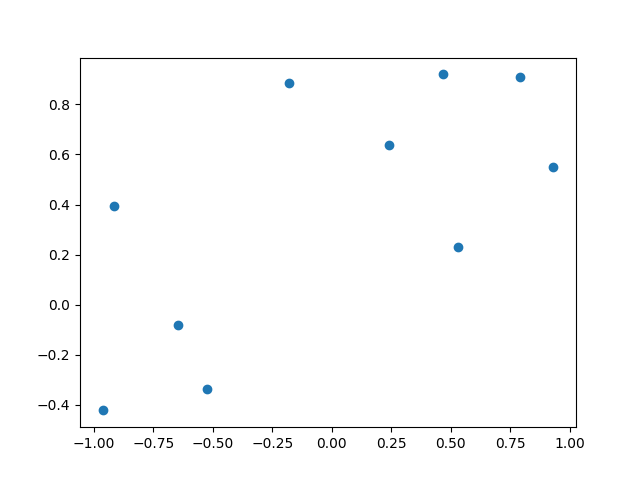

In [45]:
x=[p[0] for p in points]
y=[p[1] for p in points]
plt.scatter(x,y)